In [1]:
# Imports the Google Cloud client library
from google.cloud import storage

In [115]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import plotly.tools as tls
import seaborn.apionly as sns
from matplotlib import rcParams
import matplotlib.dates as mdates
from matplotlib.colors import SymLogNorm as symlog
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf

#import shapefile
import shapefile
from descartes.patch import PolygonPatch


In [119]:
import urllib.request
import zipfile
import random
import itertools
import math
import csv
import geopandas as gpd
import pysal 
from shapely.geometry import Polygon
import os
import pandas as pd
from google.cloud import bigquery
import numpy as np
import seaborn as sns
# import and load for bokeh plots
from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper

In [120]:
from skimage import exposure
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
import plotly.plotly as py
import plotly.graph_objs as go
from shapely import wkt

In [6]:
# Your Google Cloud Platform project ID
project_id = 347003961698

client = bigquery.Client(project="nyc-texi-data-analysis")

In [7]:
%load_ext google.cloud.bigquery

In [8]:
def bigQueryToDF(sql):
    return client.query(sql).to_dataframe()

In [9]:
TaxiAoneGeom_sql = """
select * from  `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` 
"""
TaxiAoneGeomDF = bigQueryToDF(TaxiAoneGeom_sql)

In [10]:
TaxiAoneGeomDF.head(5)

,zone_id,zone_name,borough,zone_geom
0,1,Newark Airport,EWR,"POLYGON((-74.1856319999999 40.6916479999999, -..."
1,3,Allerton/Pelham Gardens,Bronx,"POLYGON((-73.848596761 40.8716707849999, -73.8..."
2,18,Bedford Park,Bronx,"POLYGON((-73.8844286139999 40.8668003789999, -..."
3,20,Belmont,Bronx,"POLYGON((-73.8839239579998 40.8644177609999, -..."
4,31,Bronx Park,Bronx,"POLYGON((-73.8710017319999 40.8572767429999, -..."


In [11]:
YellowTaxiMain2015_sql = """
select * from(
select tz_pu.zone_id as pickup_zone_id,
    tz_pu.zone_name as pickup_zone_name,
    tz_pu.borough as pickup_borough,
    tz_do.zone_id as dropoff_zone_id,
    tz_do.zone_name as dropoff_zone_name,
    tz_do.borough as dropoff_borough,
    vendor_id,    
    CONCAT(tz_pu.borough,"-",tz_do.borough) as route_borough,
    CONCAT(tz_pu.zone_name,"-",tz_do.zone_name) as route_zone_name,
    EXTRACT (YEAR FROM pickup_datetime) AS pickup_year,
    FORMAT_DATETIME("%Y-%m",pickup_datetime) as pickup_year_mth,
    FORMAT_DATE('%A',DATE(pickup_datetime)) AS pickup_weekday, 
    EXTRACT (HOUR FROM pickup_datetime) AS pickup_hour,
    (CASE WHEN (EXTRACT (HOUR FROM pickup_datetime) between 6 and 8) THEN 'pickup_AM_PEAK' 
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 9 and 14) THEN 'pickup_MID_DAY'
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 15 and 18) THEN 'pickup_PM_PEAK'
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 19 and 21) THEN 'pickup_EVENING'   
    ELSE 'pickup_EARLY' 
 END) pickup_timeofday,
    EXTRACT (YEAR FROM dropoff_datetime) AS dropoff_year,
    FORMAT_DATETIME("%Y-%m",dropoff_datetime) as dropoff_year_mth,
    EXTRACT (DAYOFWEEK FROM dropoff_datetime) AS dropoff_weekday,
    EXTRACT (HOUR FROM dropoff_datetime) AS dropoff_hour,
    (CASE WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 6 and 8) THEN 'dropoff_AM_PEAK' 
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 9 and 14) THEN 'dropoff_MID_DAY'
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 115 and 18) THEN 'dropoff_PM_PEAK'
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 19 and 21) THEN 'dropoff_EVENING'   
    ELSE 'dropoff_EARLY' 
 END) dropoff_timeofday,
AVG(passenger_count) AS avg_passengers_cnt, 
SUM(DATETIME_DIFF(dropoff_datetime,pickup_datetime,SECOND)) as trip_duration_in_secs,
count(*) trip_count
 from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
INNER JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` tz_pu ON 
(ST_DWithin(tz_pu.zone_geom,ST_GeogPoint(pickup_longitude, pickup_latitude), 0))
/* find the boroughs and zone names for dropoff locations */
INNER JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` tz_do ON 
(ST_DWithin(tz_do.zone_geom,ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0))
where EXTRACT (YEAR FROM pickup_datetime) = 2015
and EXTRACT (YEAR FROM dropoff_datetime) = 2015 
and ((pickup_latitude BETWEEN -90 AND 90) and (pickup_longitude BETWEEN -180 AND 180)) 
and ((dropoff_latitude BETWEEN -90 AND 90) and (dropoff_longitude BETWEEN -180 AND 180))
and  passenger_count > 0 
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
order by 22 desc
)Q
where trip_count > 100
"""
YellowTaxiMainDF2015 = bigQueryToDF(YellowTaxiMain2015_sql)

In [12]:
len(YellowTaxiMainDF2015)

45465

In [13]:
YellowTaxiMainDF2015.head(5)

,pickup_zone_id,pickup_zone_name,pickup_borough,dropoff_zone_id,dropoff_zone_name,dropoff_borough,vendor_id,route_borough,route_zone_name,pickup_year,...,pickup_hour,pickup_timeofday,dropoff_year,dropoff_year_mth,dropoff_weekday,dropoff_hour,dropoff_timeofday,avg_passengers_cnt,trip_duration_in_secs,trip_count
0,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2015,...,18,pickup_PM_PEAK,2015,2015-09,4,18,dropoff_EARLY,1.927790,166152,457
1,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2015,...,18,pickup_PM_PEAK,2015,2015-06,3,18,dropoff_EARLY,2.015556,157794,450
2,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,1,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2015,...,18,pickup_PM_PEAK,2015,2015-10,5,18,dropoff_EARLY,1.190045,179674,442
3,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,1,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2015,...,15,pickup_PM_PEAK,2015,2015-04,5,15,dropoff_EARLY,1.222727,200449,440
4,79,East Village,Manhattan,79,East Village,Manhattan,2,Manhattan-Manhattan,East Village-East Village,2015,...,1,pickup_EARLY,2015,2015-01,7,1,dropoff_EARLY,2.133028,119755,436


In [14]:
YellowTaxiMain2016_sql = """
select * from(
select tz_pu.zone_id as pickup_zone_id,
    tz_pu.zone_name as pickup_zone_name,
    tz_pu.borough as pickup_borough,
    tz_do.zone_id as dropoff_zone_id,
    tz_do.zone_name as dropoff_zone_name,
    tz_do.borough as dropoff_borough,
    vendor_id,    
    CONCAT(tz_pu.borough,"-",tz_do.borough) as route_borough,
    CONCAT(tz_pu.zone_name,"-",tz_do.zone_name) as route_zone_name,
    EXTRACT (YEAR FROM pickup_datetime) AS pickup_year,
    FORMAT_DATETIME("%Y-%m",pickup_datetime) as pickup_year_mth,
    FORMAT_DATE('%A',DATE(pickup_datetime)) AS pickup_weekday, 
    EXTRACT (HOUR FROM pickup_datetime) AS pickup_hour,
    (CASE WHEN (EXTRACT (HOUR FROM pickup_datetime) between 6 and 8) THEN 'pickup_AM_PEAK' 
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 9 and 14) THEN 'pickup_MID_DAY'
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 15 and 18) THEN 'pickup_PM_PEAK'
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 19 and 21) THEN 'pickup_EVENING'   
    ELSE 'pickup_EARLY' 
 END) pickup_timeofday,
    EXTRACT (YEAR FROM dropoff_datetime) AS dropoff_year,
    FORMAT_DATETIME("%Y-%m",dropoff_datetime) as dropoff_year_mth,
    EXTRACT (DAYOFWEEK FROM dropoff_datetime) AS dropoff_weekday,
    EXTRACT (HOUR FROM dropoff_datetime) AS dropoff_hour,
    (CASE WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 6 and 8) THEN 'dropoff_AM_PEAK' 
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 9 and 14) THEN 'dropoff_MID_DAY'
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 115 and 18) THEN 'dropoff_PM_PEAK'
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 19 and 21) THEN 'dropoff_EVENING'   
    ELSE 'dropoff_EARLY' 
 END) dropoff_timeofday,
AVG(passenger_count) AS avg_passengers_cnt, 
SUM(DATETIME_DIFF(dropoff_datetime,pickup_datetime,SECOND)) as trip_duration_in_secs,
count(*) trip_count
 from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016` 
INNER JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` tz_pu ON 
(ST_DWithin(tz_pu.zone_geom,ST_GeogPoint(pickup_longitude, pickup_latitude), 0))
/* find the boroughs and zone names for dropoff locations */
INNER JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` tz_do ON 
(ST_DWithin(tz_do.zone_geom,ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0))
where EXTRACT (YEAR FROM pickup_datetime) = 2016
and EXTRACT (YEAR FROM dropoff_datetime) = 2016
and ((pickup_latitude BETWEEN -90 AND 90) and (pickup_longitude BETWEEN -180 AND 180)) 
and ((dropoff_latitude BETWEEN -90 AND 90) and (dropoff_longitude BETWEEN -180 AND 180))
and  passenger_count > 0 
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
order by 22 desc
)Q
where trip_count > 100
"""
YellowTaxiMainDF2016 = bigQueryToDF(YellowTaxiMain2016_sql)

In [15]:
YellowTaxiMainDF2016.head(5)

,pickup_zone_id,pickup_zone_name,pickup_borough,dropoff_zone_id,dropoff_zone_name,dropoff_borough,vendor_id,route_borough,route_zone_name,pickup_year,...,pickup_hour,pickup_timeofday,dropoff_year,dropoff_year_mth,dropoff_weekday,dropoff_hour,dropoff_timeofday,avg_passengers_cnt,trip_duration_in_secs,trip_count
0,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2016,...,18,pickup_PM_PEAK,2016,2016-06,4,18,dropoff_EARLY,1.874739,175517,479
1,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2016,...,18,pickup_PM_PEAK,2016,2016-05,3,18,dropoff_EARLY,1.888651,186271,467
2,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2016,...,17,pickup_PM_PEAK,2016,2016-06,5,17,dropoff_EARLY,2.009217,141325,434
3,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2016,...,18,pickup_PM_PEAK,2016,2016-06,5,18,dropoff_EARLY,1.995327,143754,428
4,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2016,...,14,pickup_MID_DAY,2016,2016-05,3,14,dropoff_MID_DAY,1.967136,214916,426


In [16]:
len(YellowTaxiMainDF2016)

21760

In [17]:
YellowTaxiMain2017_sql = """
select * from(
select tz_pu.zone_id as pickup_zone_id,
    tz_pu.zone_name as pickup_zone_name,
    tz_pu.borough as pickup_borough,
    tz_do.zone_id as dropoff_zone_id,
    tz_do.zone_name as dropoff_zone_name,
    tz_do.borough as dropoff_borough,
    vendor_id,    
    CONCAT(tz_pu.borough,"-",tz_do.borough) as route_borough,
    CONCAT(tz_pu.zone_name,"-",tz_do.zone_name) as route_zone_name,
    EXTRACT (YEAR FROM pickup_datetime) AS pickup_year,
    FORMAT_DATETIME("%Y-%m",pickup_datetime) as pickup_year_mth,
    FORMAT_DATE('%A',DATE(pickup_datetime)) AS pickup_weekday, 
    EXTRACT (HOUR FROM pickup_datetime) AS pickup_hour,
    (CASE WHEN (EXTRACT (HOUR FROM pickup_datetime) between 6 and 8) THEN 'pickup_AM_PEAK' 
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 9 and 14) THEN 'pickup_MID_DAY'
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 15 and 18) THEN 'pickup_PM_PEAK'
    WHEN (EXTRACT (HOUR FROM pickup_datetime) between 19 and 21) THEN 'pickup_EVENING'   
    ELSE 'pickup_EARLY' 
 END) pickup_timeofday,
    EXTRACT (YEAR FROM dropoff_datetime) AS dropoff_year,
    FORMAT_DATETIME("%Y-%m",dropoff_datetime) as dropoff_year_mth,
    EXTRACT (DAYOFWEEK FROM dropoff_datetime) AS dropoff_weekday,
    EXTRACT (HOUR FROM dropoff_datetime) AS dropoff_hour,
    (CASE WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 6 and 8) THEN 'dropoff_AM_PEAK' 
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 9 and 14) THEN 'dropoff_MID_DAY'
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 115 and 18) THEN 'dropoff_PM_PEAK'
    WHEN (EXTRACT (HOUR FROM dropoff_datetime) between 19 and 21) THEN 'dropoff_EVENING'   
    ELSE 'dropoff_EARLY' 
 END) dropoff_timeofday,
AVG(passenger_count) AS avg_passengers_cnt, 
SUM(DATETIME_DIFF(dropoff_datetime,pickup_datetime,SECOND)) as trip_duration_in_secs,
count(*) trip_count
 from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017` 
INNER JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` tz_pu ON 
tz_pu.zone_id = pickup_location_id
/* find the boroughs and zone names for dropoff locations */
INNER JOIN `bigquery-public-data.new_york_taxi_trips.taxi_zone_geom` tz_do ON 
tz_pu.zone_id = dropoff_location_id
where EXTRACT (YEAR FROM pickup_datetime) = 2017
and EXTRACT (YEAR FROM dropoff_datetime) = 2017 
and  passenger_count > 0 
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
order by 22 desc
)Q
where trip_count > 100
"""
YellowTaxiMainDF2017 = bigQueryToDF(YellowTaxiMain2017_sql)

In [34]:
YellowTaxiMainDF2017.head(5)

,pickup_zone_id,pickup_zone_name,pickup_borough,dropoff_zone_id,dropoff_zone_name,dropoff_borough,vendor_id,route_borough,route_zone_name,pickup_year,...,pickup_hour,pickup_timeofday,dropoff_year,dropoff_year_mth,dropoff_weekday,dropoff_hour,dropoff_timeofday,avg_passengers_cnt,trip_duration_in_secs,trip_count
0,236,Upper East Side North,Manhattan,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,2,Manhattan-Manhattan,Upper East Side North-Governor's Island/Ellis ...,2017,...,15,pickup_PM_PEAK,2017,2017-01,3,15,dropoff_EARLY,2.076923,469128,1326
1,236,Upper East Side North,Manhattan,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,2,Manhattan-Manhattan,Upper East Side North-Governor's Island/Ellis ...,2017,...,12,pickup_MID_DAY,2017,2017-01,3,12,dropoff_MID_DAY,1.860190,360864,1266
2,236,Upper East Side North,Manhattan,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,2,Manhattan-Manhattan,Upper East Side North-Governor's Island/Ellis ...,2017,...,15,pickup_PM_PEAK,2017,2017-12,6,15,dropoff_EARLY,1.930120,427482,1245
3,236,Upper East Side North,Manhattan,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,2,Manhattan-Manhattan,Upper East Side North-Governor's Island/Ellis ...,2017,...,18,pickup_PM_PEAK,2017,2017-10,3,18,dropoff_EARLY,1.918919,300492,1221
4,236,Upper East Side North,Manhattan,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,2,Manhattan-Manhattan,Upper East Side North-Governor's Island/Ellis ...,2017,...,8,pickup_AM_PEAK,2017,2017-01,3,8,dropoff_AM_PEAK,1.854271,377643,1194


In [35]:
len(YellowTaxiMainDF2017)

1592124

In [36]:
##### Combine all the 3 dataframes ######################

In [37]:
YellowCombined = pd.concat([YellowTaxiMainDF2015, YellowTaxiMainDF2016,YellowTaxiMainDF2017])

In [38]:
len(YellowCombined)

1659349

In [39]:
########################################## aggregate data #######################################

In [59]:
# Get pickup count of the trips by location id  
df_all_pu = YellowCombined.groupby(['pickup_weekday','pickup_hour'],as_index=False).agg({'trip_count':"sum"})

In [60]:
df_all_pu.head(3)

,pickup_weekday,pickup_hour,trip_count
0,Friday,0,363797
1,Friday,1,201325
2,Friday,2,9699


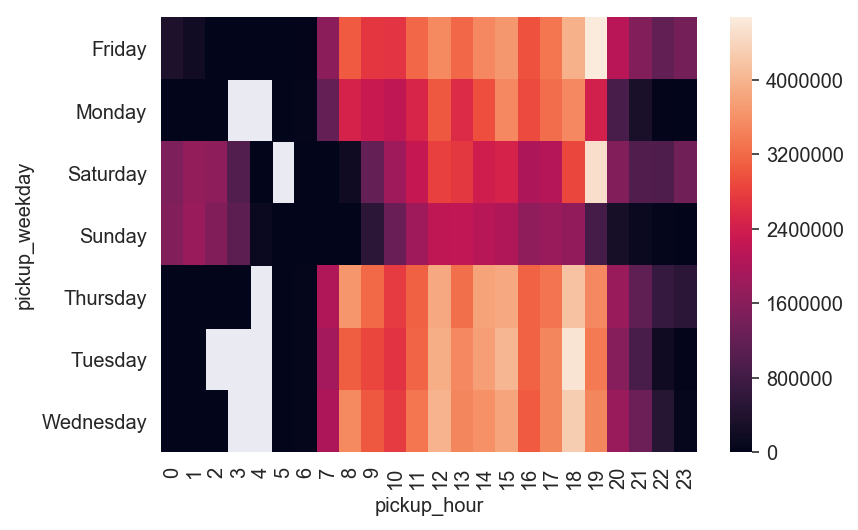

In [61]:
yellow2015pickup = df_all_pu.pivot("pickup_weekday", "pickup_hour", "trip_count")
htmap = sns.heatmap(yellow2015pickup)

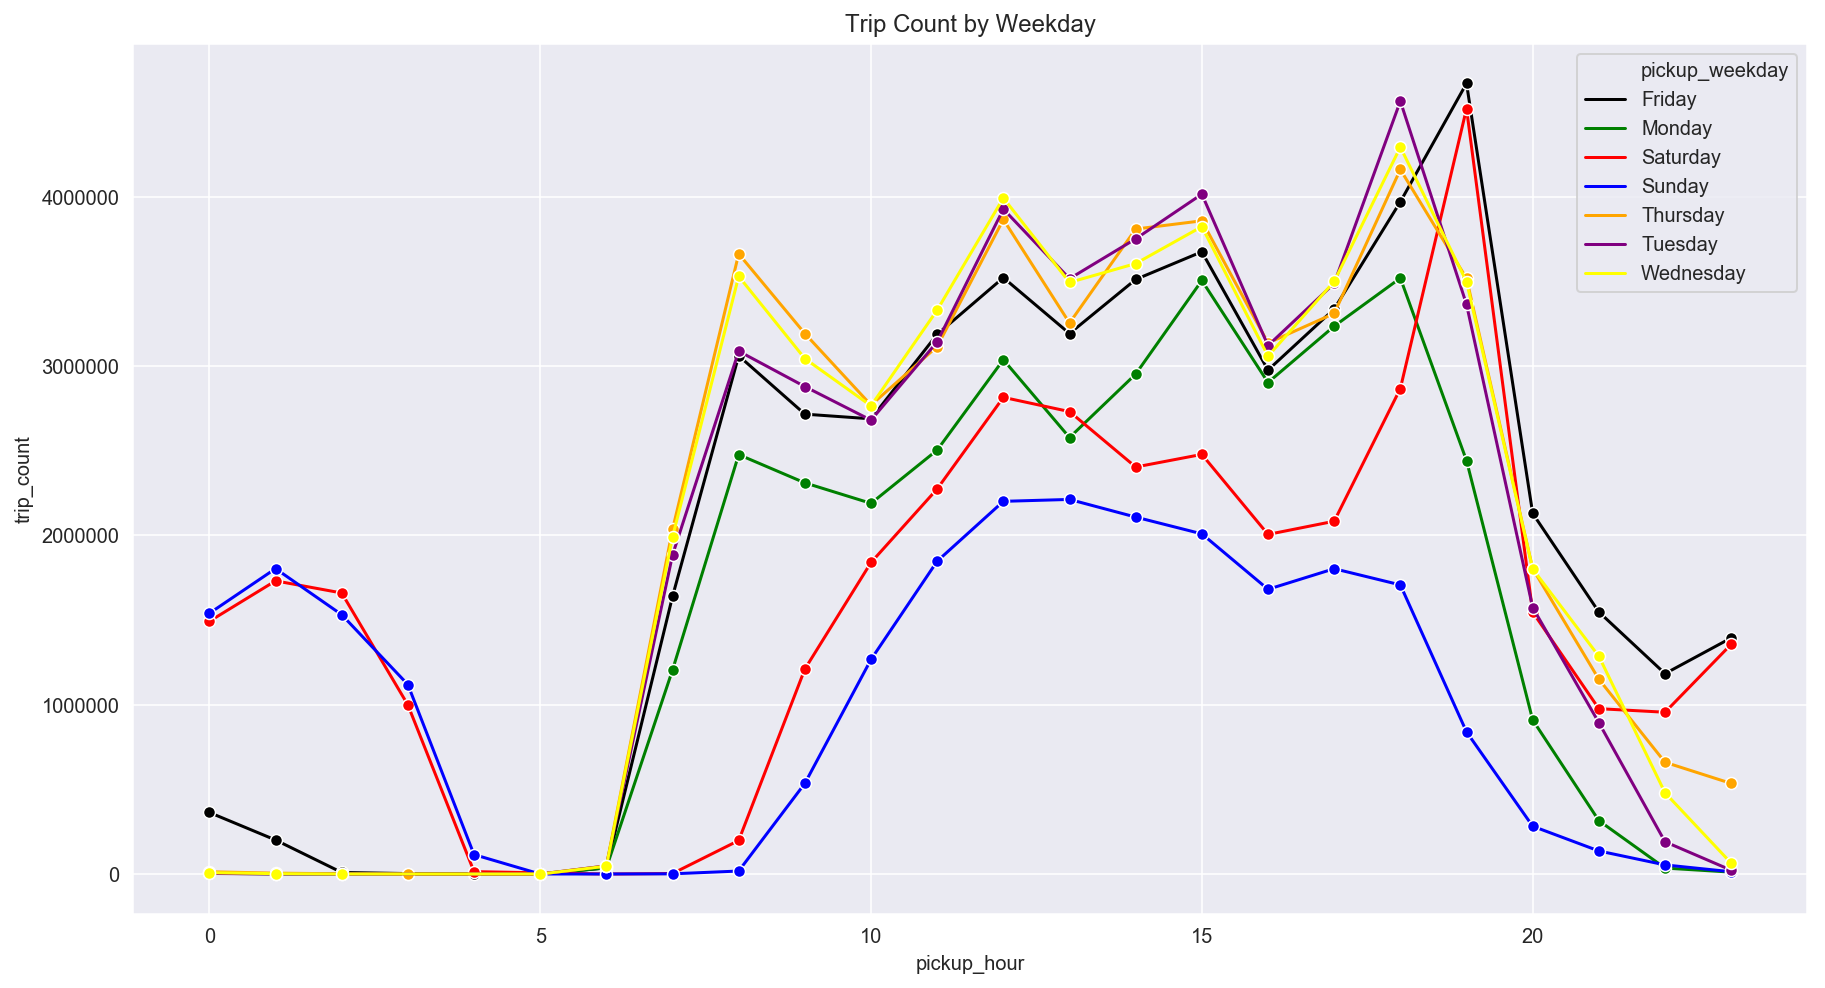

In [62]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,8))
plt.title("Trip Count by Weekday")
ax = sns.lineplot(data=df_all_pu, x='pickup_hour', y='trip_count', hue='pickup_weekday',marker="o",palette=["black","green","red","blue","orange","purple","yellow"])


In [ ]:
#########################find most popular routes################################

In [97]:
# Get pickup count of the trips by location id  
RoutesDF = YellowCombined.groupby(['route_zone_name'],as_index=False).agg({'trip_count':"sum"}).sort_values(by=['trip_count'],ascending=False)


In [98]:
RoutesDFTop5 = RoutesDF.head(5)

In [99]:
RoutesDFTop5

,route_zone_name,trip_count
3878,Upper East Side North-Governor's Island/Ellis ...,1439148
4138,Upper East Side South-Governor's Island/Ellis ...,1309347
4271,Upper East Side South-Upper East Side North,1226119
4011,Upper East Side North-Upper East Side North,1127115
4012,Upper East Side North-Upper East Side South,1101252


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



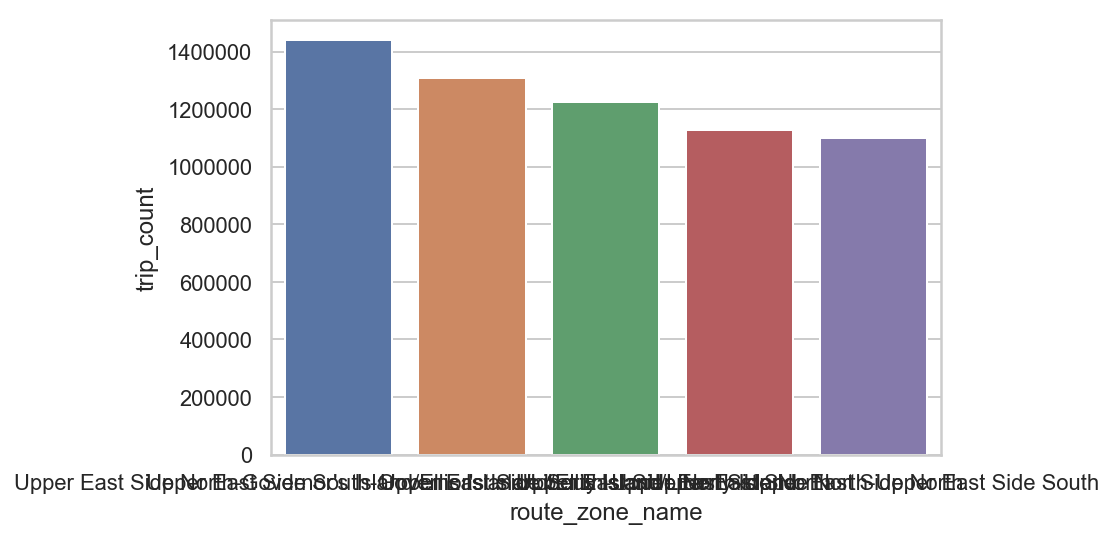

In [110]:
sns.distplot(RoutesDFTop5.trip_count, kde=False, rug=True);

sns.set(style="whitegrid")
#trips = sns.load_dataset("RoutesDFTop5")
ax = sns.barplot(x="route_zone_name", y="trip_count",data=RoutesDFTop5)
#ax = sns.countplot(x="route_zone_name",y="trip_count",data=RoutesDFTop5)

In [149]:
TopZonecombinedDF = YellowCombined[YellowCombined['route_zone_name'].str.contains("Upper East Side North-Governor's Island/Ellis")]

In [152]:
TopZonecombinedDF.head(3)

,pickup_zone_id,pickup_zone_name,pickup_borough,dropoff_zone_id,dropoff_zone_name,dropoff_borough,vendor_id,route_borough,route_zone_name,pickup_year,...,pickup_hour,pickup_timeofday,dropoff_year,dropoff_year_mth,dropoff_weekday,dropoff_hour,dropoff_timeofday,avg_passengers_cnt,trip_duration_in_secs,trip_count
0,236,Upper East Side North,Manhattan,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,2,Manhattan-Manhattan,Upper East Side North-Governor's Island/Ellis ...,2017,...,15,pickup_PM_PEAK,2017,2017-01,3,15,dropoff_EARLY,2.076923,469128,1326
1,236,Upper East Side North,Manhattan,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,2,Manhattan-Manhattan,Upper East Side North-Governor's Island/Ellis ...,2017,...,12,pickup_MID_DAY,2017,2017-01,3,12,dropoff_MID_DAY,1.860190,360864,1266
2,236,Upper East Side North,Manhattan,103,Governor's Island/Ellis Island/Liberty Island,Manhattan,2,Manhattan-Manhattan,Upper East Side North-Governor's Island/Ellis ...,2017,...,15,pickup_PM_PEAK,2017,2017-12,6,15,dropoff_EARLY,1.930120,427482,1245


In [153]:
# Get pickup count of the trips by location id  
TopZonecombinedDF = TopZonecombinedDF.groupby(['route_zone_name','pickup_year_mth'],as_index=False).agg({'trip_count':"sum"})

In [154]:
TopZonecombinedDF.head(2)

,route_zone_name,pickup_year_mth,trip_count
0,Upper East Side North-Governor's Island/Ellis ...,2017-01,137970
1,Upper East Side North-Governor's Island/Ellis ...,2017-02,117912


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



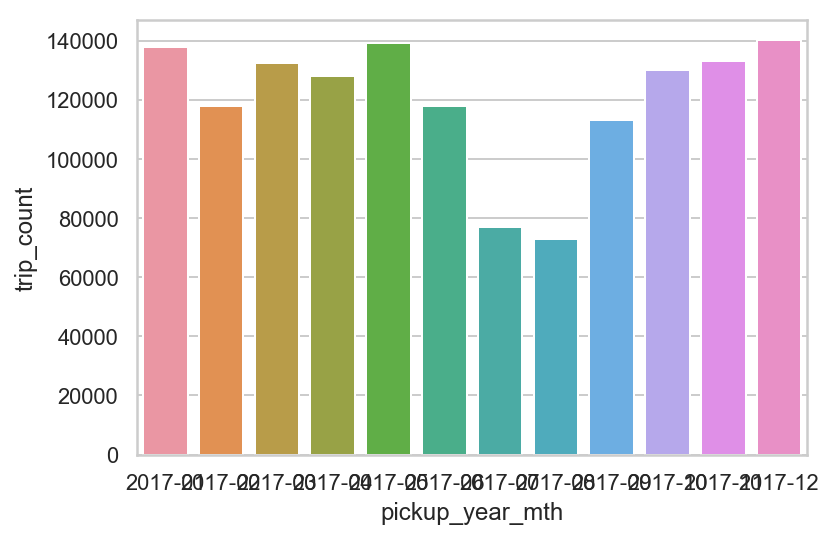

In [157]:
sns.distplot(TopZonecombinedDF.trip_count, kde=False, rug=True);

sns.set(style="whitegrid")
#trips = sns.load_dataset("RoutesDFTop5")
ax = sns.barplot(x="pickup_year_mth", y="trip_count",data=TopZonecombinedDF)
#ax = sns.countplot(x="route_zone_name",y="trip_count",data=RoutesDFTop5)

In [ ]:
#########################find most popular routes################################

In [ ]:
#***************************************************************************************************************************

In [ ]:
#get geom for each of the locations:
ZonecombinedDF = YellowCombined.join(TaxiAoneGeomDF.set_index('zone_id'), on='pickup_zone_id')

In [50]:
ZonecombinedDF.head(3)

,pickup_zone_id,pickup_zone_name,pickup_borough,dropoff_zone_id,dropoff_zone_name,dropoff_borough,vendor_id,route_borough,route_zone_name,pickup_year,...,dropoff_year_mth,dropoff_weekday,dropoff_hour,dropoff_timeofday,avg_passengers_cnt,trip_duration_in_secs,trip_count,zone_name,borough,zone_geom
0,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2015,...,2015-09,4,18,dropoff_EARLY,1.927790,166152,457,Upper East Side South,Manhattan,"POLYGON((-73.9656696 40.7628045559999, -73.965..."
1,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,2,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2015,...,2015-06,3,18,dropoff_EARLY,2.015556,157794,450,Upper East Side South,Manhattan,"POLYGON((-73.9656696 40.7628045559999, -73.965..."
2,237,Upper East Side South,Manhattan,236,Upper East Side North,Manhattan,1,Manhattan-Manhattan,Upper East Side South-Upper East Side North,2015,...,2015-10,5,18,dropoff_EARLY,1.190045,179674,442,Upper East Side South,Manhattan,"POLYGON((-73.9656696 40.7628045559999, -73.965..."


In [56]:
# Get pickup count of the trips by location id  
SelectedZoneDF = ZonecombinedDF.groupby(['pickup_zone_id','pickup_zone_name','pickup_borough','zone_geom'],as_index=False).agg({'trip_count':"sum"})

In [57]:
SelectedZoneDF.head(10)

,pickup_zone_id,pickup_zone_name,pickup_borough,zone_geom,trip_count
0,100,Garment District,Manhattan,"POLYGON((-73.986849911 40.7510816789999, -73.9...",122237
1,107,Gramercy,Manhattan,"POLYGON((-73.982322826 40.7314978899999, -73.9...",405331
2,113,Greenwich Village North,Manhattan,"POLYGON((-73.9913586919999 40.72778247, -73.99...",28856
3,114,Greenwich Village South,Manhattan,"POLYGON((-73.992326422 40.7249082319999, -73.9...",22615
4,13,Battery Park City,Manhattan,"POLYGON((-74.012554689 40.719069863, -74.01270...",21072
5,132,JFK Airport,Queens,MULTIPOLYGON(((-73.7470431634215 40.6375664264...,693593
6,137,Kips Bay,Manhattan,"POLYGON((-73.97223566211 40.7404054152252, -73...",27129
7,138,LaGuardia Airport,Queens,MULTIPOLYGON(((-73.8728849699182 40.7859626331...,49884
8,140,Lenox Hill East,Manhattan,"POLYGON((-73.9584911952082 40.7585459039152, -...",232647
9,141,Lenox Hill West,Manhattan,"POLYGON((-73.961767665 40.7598930409999, -73.9...",2503156


In [111]:
SelectedZoneDF = SelectedZoneDF.sort_values(by=['trip_count'],ascending=False)

In [112]:
SelectedZoneDF.to_csv(r'C:\Users\seemaconnect\Google_Cloud\my code\output\SelectedZoneDF.csv', sep=',', encoding='utf-8', index=False)

In [133]:
SelectedZoneDF["zone_geom"] = SelectedZoneDF["zone_geom"].apply(wkt.loads)
gdf = gpd.GeoDataFrame(SelectedZoneDF,geometry='zone_geom',crs={'init':'epsg:3006'})
gdf.plot(column='trip_count', cmap='OrRd', scheme='quantiles',figsize=(14,8));

AttributeError: 'Polygon' object has no attribute 'encode'

In [143]:
data = pd.read_csv(r'C:\Users\seemaconnect\Google_Cloud\my code\output\SelectedZoneDF.csv')
data["zone_geom"] = data["zone_geom"].apply(wkt.loads)

In [144]:
data.head(2)

,pickup_zone_id,pickup_zone_name,pickup_borough,zone_geom,trip_count
0,236,Upper East Side North,Manhattan,"POLYGON ((-73.9572940999999 40.7742835549999, ...",114825427
1,237,Upper East Side South,Manhattan,"POLYGON ((-73.9656696 40.7628045559999, -73.96...",103231986


In [145]:
gdf = gpd.GeoDataFrame(data,geometry='zone_geom',crs={'init':'epsg:3006'})

ImportError: PySAL is required to use the 'scheme' keyword

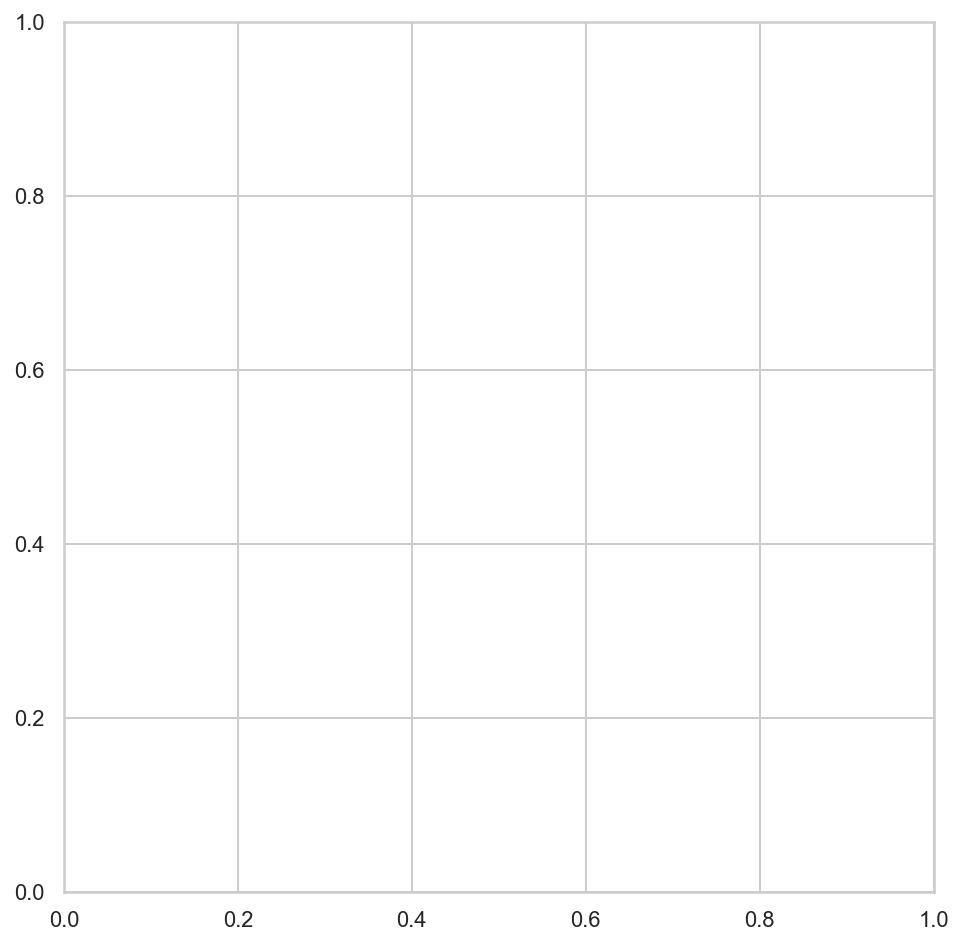

In [147]:
gdf.plot(column='trip_count',scheme='quantiles',cmap='OrRd',figsize=(14,8));